In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6*1024)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


2026-01-26 02:40:41.026158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1769395242.436505  420660 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0


In [2]:
# Data processing and model train

from libs.ml import AtmosphericalData
from tensorflow import keras
from keras.src.callbacks import EarlyStopping
def train_model(target_column:str, date_col: str, train_column: str, n_steps:int, training_args: dict, model_args: list, compile_args: dict = None):
    ## Read data and preprocessing

    inside = []
    for v in model_args:
        layer = getattr(keras.layers, v['layer'])

        inside.append(layer(v['units'], **v['args']))

    model = keras.models.Sequential(inside)

    ad = AtmosphericalData(model=model, path=f"./data/{target_column}/{target_column}_decomposition.csv", use_cudnn=False)
    del model

    print(ad.df.columns)

    ad.convert_date(date_col=date_col)
    ad.target_selection(train_column)
    ad.data_preprocessing(n_steps=n_steps, train_vol=0.9)

    ## Train data
    ad.train_data(
        epochs=training_args['epochs'],
        batch_size=training_args['batch_size'],
        validation_split=training_args['validation_split'],
        verbose=training_args['verbose'],
        **compile_args
    )


    ## Test trained model
    ad.test_model()


    ## Plot comparison
    ad.plot_tests()

    return ad

In [3]:
target = 'tmin(degC)'

Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (777, 3, 3)
y shape: (777,)
Epoch 1/150
36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4545 - mae: 0.8350

2026-01-26 02:54:58.991116: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.4325 - mae: 0.7989 - val_loss: 0.3568 - val_mae: 0.7008
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4281 - mae: 0.7938 - val_loss: 0.3544 - val_mae: 0.6972
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4252 - mae: 0.7904 - val_loss: 0.3535 - val_mae: 0.6960
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4231 - mae: 0.7870 - val_loss: 0.3528 - val_mae: 0.6947
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4211 - mae: 0.7845 - val_loss: 0.3518 - val_mae: 0.6930
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4196 - mae: 0.7828 - val_loss: 0.3505 - val_mae: 0.6916
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4182 - mae: 0.7815 - val_loss: 0.3504 - val_mae: 0.6915
Epoch 8/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4171 - mae: 0.7799 - val_loss: 0.3507 - val_mae: 0.6917
Epoch 9/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4156 - mae: 0.

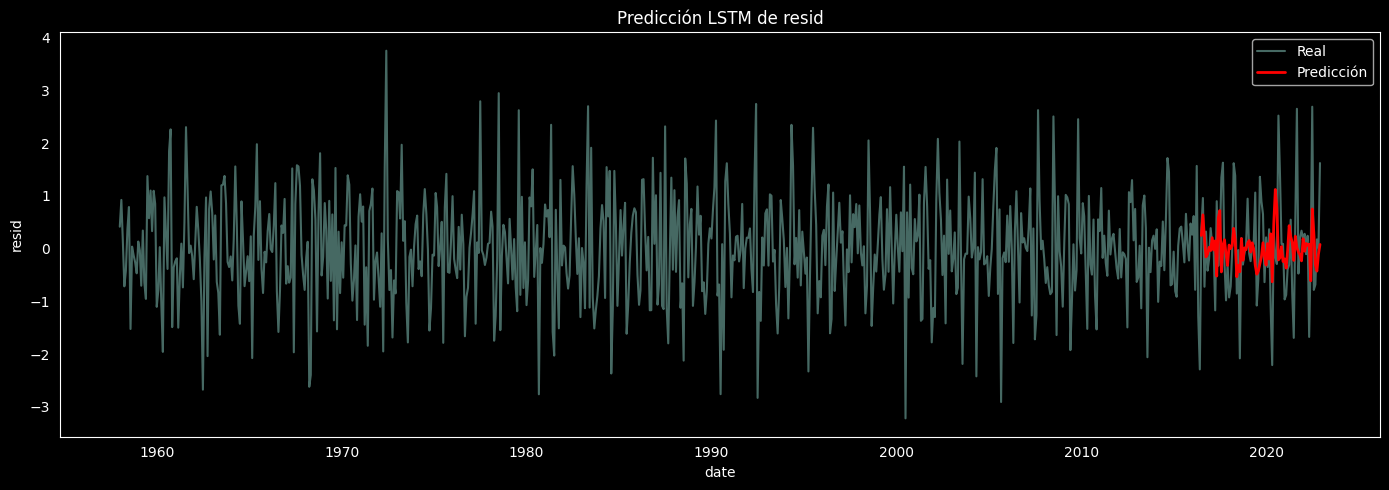

In [15]:
n_steps_r = 3

model_args_r = [
    {'layer': 'Input', 'units': (n_steps_r, 3), 'args': {}},
    {'layer': 'LSTM', 'units':16, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_r = {
    'optimizer': 'adam',
    'loss': 'huber',
    'metrics': ['mae'],
}

training_args_r = {
    'epochs': 150,
    'batch_size': 12,
    'validation_split': 0.2,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_r = train_model(
    target_column=target,
    date_col='date',
    train_column='resid',
    n_steps=n_steps_r,
    training_args=training_args_r,
    model_args=model_args_r,
    compile_args=compile_args_r
)

Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (756, 24, 3)
y shape: (756,)
Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.5872 - mse: 0.5872 - val_loss: 0.3578 - val_mse: 0.3578
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3551 - mse: 0.3551 - val_loss: 0.2752 - val_mse: 0.2752
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2333 - mse: 0.2333 - val_loss: 0.2056 - val_mse: 0.2056
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1502 - mse: 0.1502 - val_loss: 0.1382 - val_mse: 0.1382
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1190 - mse: 0.1190 - val_loss: 0.1135 - val_mse: 0.1135
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1051 - mse: 0.1051 - val_loss: 0.0797 - val_mse: 0.0797
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0981 - mse: 0.0981 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

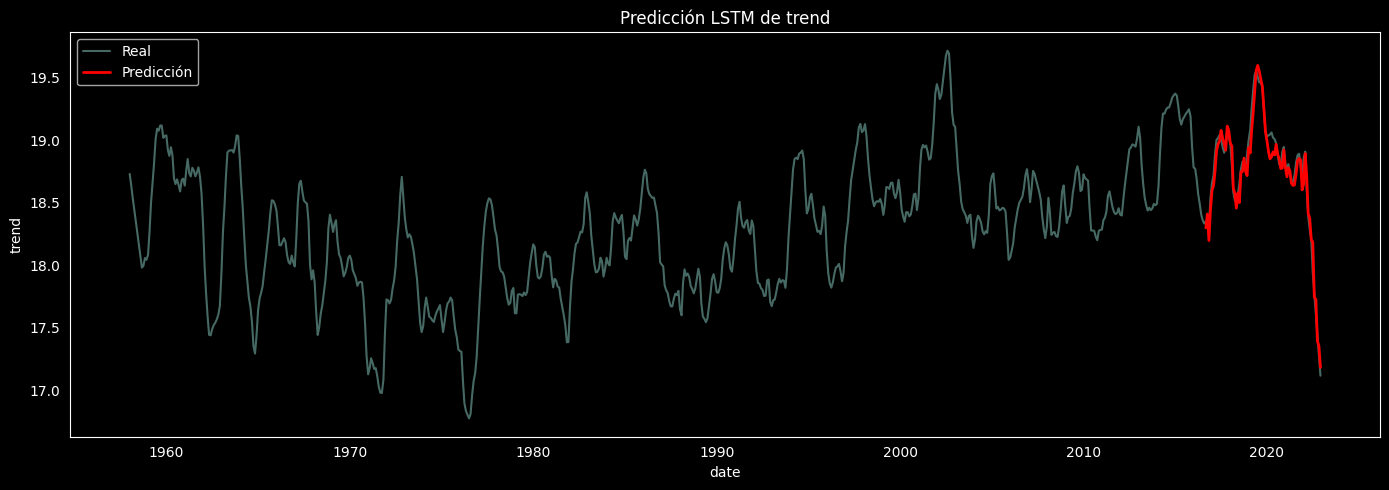

In [16]:
n_steps_t = 24
model_args_t = [
    {'layer': 'Input', 'units': (n_steps_t, 3), 'args': {}},
    {'layer': 'LSTM', 'units':64, 'args': {'return_sequences': True, 'use_cudnn': False}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_t = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_t = {
    'epochs': 150,
    'batch_size': 24,
    'validation_split': 0.15,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_t = train_model(
    target_column=target,
    date_col='date',
    train_column='trend',
    n_steps=n_steps_t,
    training_args=training_args_t,
    model_args=model_args_t,
    compile_args=compile_args_t
)


Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (768, 12, 3)
y shape: (768,)
Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.5676 - mse: 0.5676 - val_loss: 0.0994 - val_mse: 0.0994
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

2026-01-26 02:52:11.720584: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step
%RMSE: 0.42595177004985574
%MAE: 0.25506453997604306


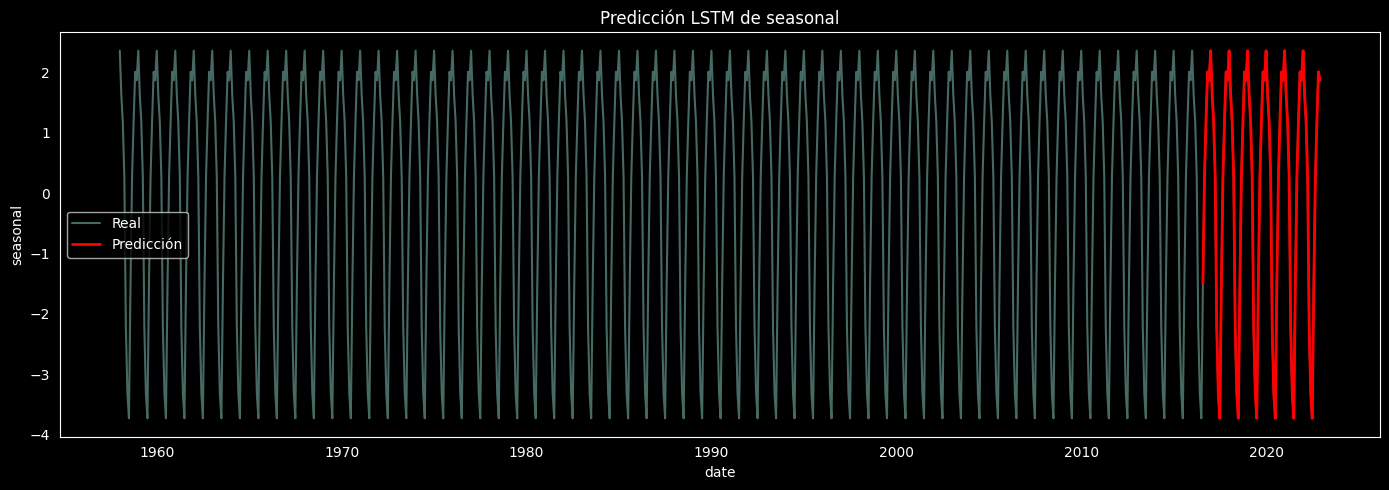

In [10]:
n_steps_s = 12

model_args_s = [
    {'layer': 'Input', 'units': (n_steps_s, 3), 'args': {}},
    {'layer': 'LSTM', 'units':48, 'args': {'return_sequences': True, 'use_cudnn': False}},
    {'layer': 'LSTM', 'units':16, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_s = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_s = {
    'epochs': 150,
    'batch_size': 16,
    'validation_split': 0.15,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_s = train_model(
    target_column=target,
    date_col='date',
    train_column='seasonal',
    n_steps=n_steps_s,
    training_args=training_args_s,
    model_args=model_args_s,
    compile_args=compile_args_s
)


Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (756, 24, 3)
y shape: (756,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
%RMSE: 106.39302044175172
%MAE: 81.28847398256


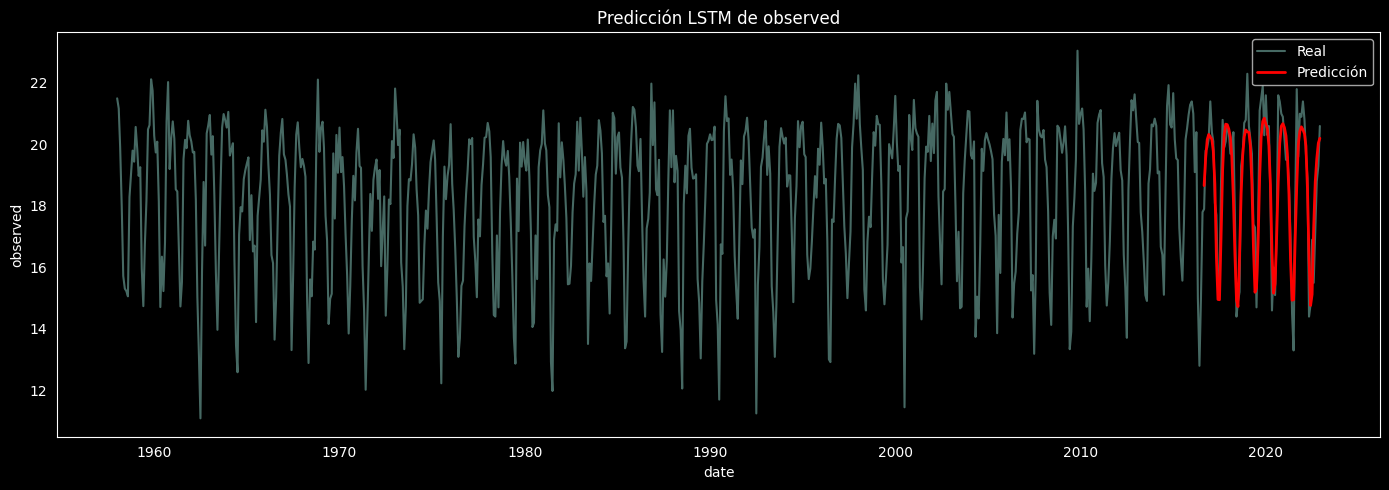

In [8]:
n_steps_o = 24

model_args_o = [
    {'layer': 'Input', 'units': (n_steps_o, 3), 'args': {}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_o = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_o = {
    'epochs': 150,
    'batch_size': 24,
    'validation_split': 0.1,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 0
}

ad_o = train_model(
    target_column=target,
    date_col='date',
    train_column='observed',
    n_steps=n_steps_o,
    training_args=training_args_o,
    model_args=model_args_o,
    compile_args=compile_args_o
)

%RMSE: 94.59338259209628
%MAE: 72.86236235969943


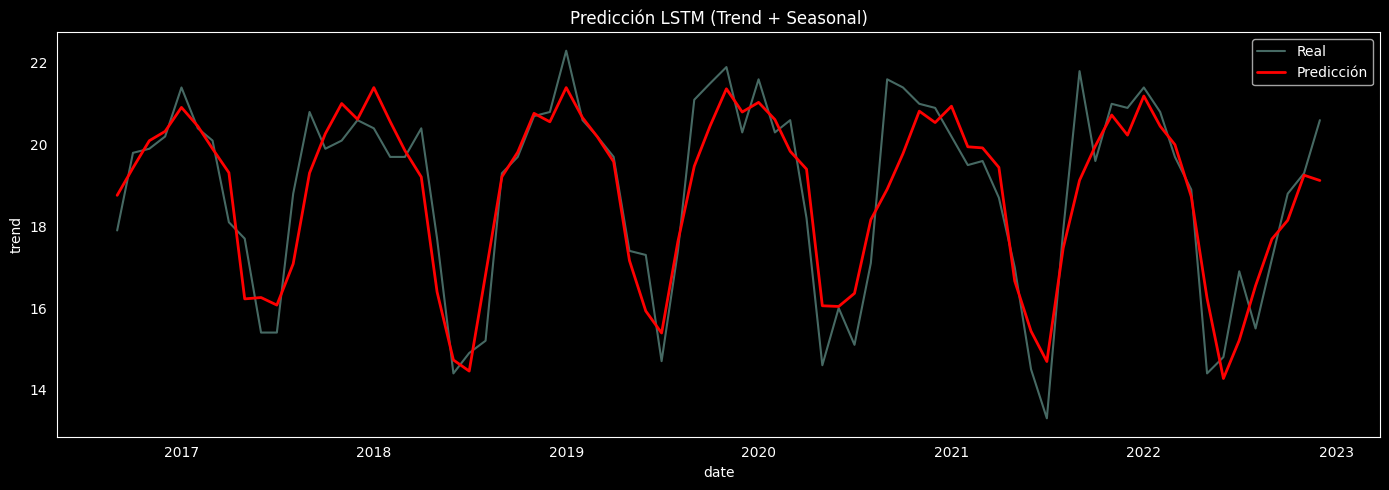

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encontrar la longitud mínima entre las predicciones verdaderas de los modelos
min_len = min(
    len(ad_r._true_rescaled),
    len(ad_t._true_rescaled),
    len(ad_s._true_rescaled)
)

# Recortar las verdaderas y predichas para que tengan la misma longitud (solo trend + seasonal)
true_rescaled = (
    ad_t._true_rescaled[-min_len:]
    + ad_s._true_rescaled[-min_len:]
    + ad_r._true_rescaled[-min_len:]
)

pred_rescaled = (
    ad_t._pred_rescaled[-min_len:]
    + ad_s._pred_rescaled[-min_len:]
    + ad_r._pred_rescaled[-min_len:]
)

# Aplanar los arrays para matplotlib
true_rescaled = true_rescaled.flatten()
pred_rescaled = pred_rescaled.flatten()

# Calcular métricas
rmse = np.sqrt(mean_squared_error(true_rescaled, pred_rescaled))
mae = mean_absolute_error(true_rescaled, pred_rescaled)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# Usar las fechas del modelo trend para el eje x, recortadas al mismo rango
dates = ad_t._test_dates[-min_len:]

# Graficar
plt.figure(figsize=(14,5))
plt.plot(dates, true_rescaled, label="Real", alpha=0.5)
plt.plot(dates, pred_rescaled, label="Predicción", color="red", linewidth=2)
plt.title("Predicción LSTM (Trend + Seasonal)")
plt.xlabel(ad_t._date_col)
plt.ylabel(ad_t._target_col)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


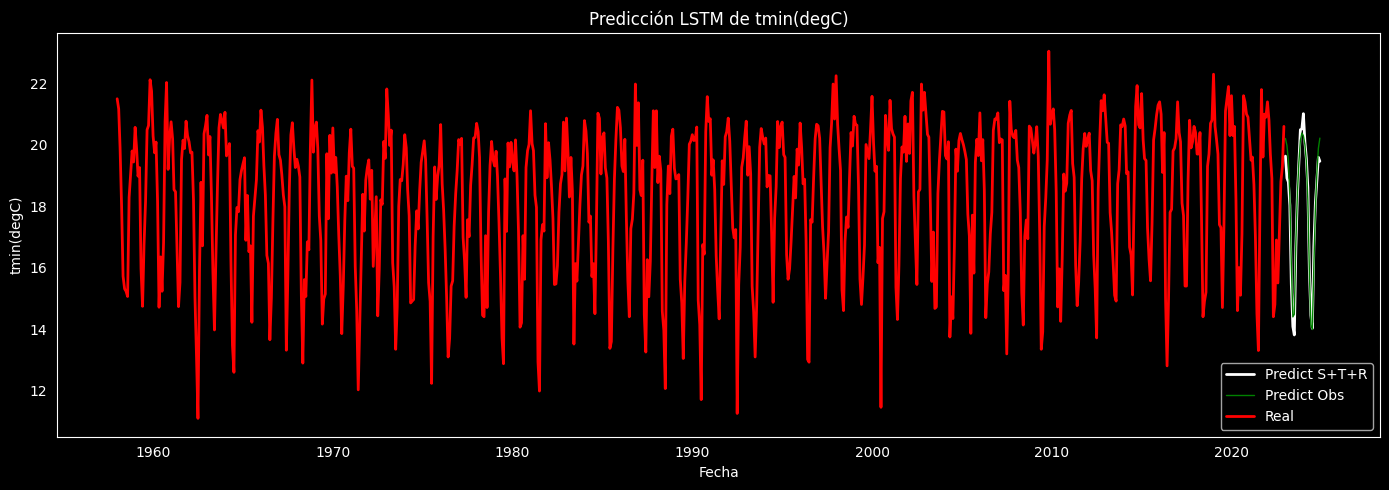

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
def build_dates(year):
    return [f'{year}{month}01' if month >= 10 else f'{year}0{month}01' for month in range(1, 13)]
dates_input = build_dates(2023)
dates_input = dates_input + build_dates(2024)
predicts = []
predicts1 = []
for date in dates_input:
    _predict = ad_r.predict_for_date(date)
    _predict += ad_t.predict_for_date(date)
    _predict += ad_s.predict_for_date(date)
    predicts.append(_predict)

    _predict = ad_o.predict_for_date(date)
    predicts1.append(_predict)


plt.figure(figsize=(14,5))
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), predicts, label="Predict S+T+R", color='white', linewidth=2)
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), predicts1, label="Predict Obs", color='green', linewidth=1)
plt.plot(ad_r.df['date'], ad_r.df['observed'], label="Real", color="red", linewidth=2)
plt.title("Predicción LSTM de " + target)
plt.xlabel("Fecha")
plt.ylabel(target)
plt.legend()
plt.grid()
plt.tight_layout()